# India Gender and Region-Type Analysis with Visualizations

This notebook analyzes India gender population data (2011) and enriches it with region type (state vs UT) from a caste/region scaffold. It produces insights and visualizations, and saves cleaned outputs for reuse.

- Data sources used here are local CSVs provided in the workspace.
- The caste CSV is a scaffold; only region_type is used for enrichment.
- Visualizations use seaborn/matplotlib; choropleth is optional.


In [31]:
# Section 1: Import Libraries and Notebook Setup
import os
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

# Optional: plotly for extra visuals
try:
    import plotly.express as px  # noqa: F401
except Exception:
    px = None

# Configure display
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 120)

# Style
sns.set_theme(style="whitegrid", context="notebook")

# Detect Kaggle environment and set paths
IS_KAGGLE = Path("/kaggle").exists() or ("KAGGLE_KERNEL_RUN_TYPE" in os.environ)
WORK_ROOT = Path.cwd()
OUTPUT_ROOT = Path("/kaggle/working") if IS_KAGGLE else WORK_ROOT

OUT_DIR = OUTPUT_ROOT / "figures"
OUT_DIR.mkdir(parents=True, exist_ok=True)
RESULTS_DIR = OUTPUT_ROOT / "cache"
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

# Helper: find data files in common locations (local repo or Kaggle inputs)
def find_data_file(filename: str) -> Path | None:
    candidates = []
    # Local common spots relative to current working dir
    for p in [WORK_ROOT, WORK_ROOT / "datasets", WORK_ROOT.parent / "datasets", WORK_ROOT.parent, *WORK_ROOT.parents]:
        if p and p.exists():
            fp = p / filename
            candidates.append(fp)
    # Kaggle inputs (recursive search)
    kaggle_input = Path("/kaggle/input")
    if kaggle_input.exists():
        for fp in kaggle_input.rglob(filename):
            candidates.append(fp)
    # Direct path in cwd
    candidates.append(Path(filename))
    for fp in candidates:
        if fp.exists():
            return fp.resolve()
    return None

print(f"Environment: {'Kaggle' if IS_KAGGLE else 'Local'}")
print(f"Working dir: {WORK_ROOT}")
print(f"Figures -> {OUT_DIR}")
print(f"Cache   -> {RESULTS_DIR}")

Environment: Local
Working dir: c:\Users\abhis\Downloads\data Science 2.0\notebooks
Figures -> c:\Users\abhis\Downloads\data Science 2.0\notebooks\figures
Cache   -> c:\Users\abhis\Downloads\data Science 2.0\notebooks\cache


In [32]:
# Section 2: Load CSVs (Gender and Caste/Region)
# Try common filenames; allow dataset to be uploaded or in Kaggle /kaggle/input/*
GENDER_NAME = "india_gender_population.csv"
CASTE_NAME = "india_caste_census_state_ut.csv"

gender_path = find_data_file(GENDER_NAME)
caste_path = find_data_file(CASTE_NAME)

if gender_path is None:
    raise FileNotFoundError(f"Could not find {GENDER_NAME}. Upload it to this notebook or place it under datasets/ or /kaggle/input.")
if caste_path is None:
    raise FileNotFoundError(f"Could not find {CASTE_NAME}. Upload it to this notebook or place it under datasets/ or /kaggle/input.")

# Explicit NA handling
na_vals = ["", "NA", "N/A", "na", "n/a", "null", "None"]

# Load gender data
gender_raw = pd.read_csv(gender_path, na_values=na_vals, dtype={
    "State_UT": str,
    "Males": 'Int64',
    "Females": 'Int64',
    "Total_Population": 'Int64',
})

# Load caste/region scaffold
caste_raw = pd.read_csv(caste_path, na_values=na_vals)

# Strip whitespace in string columns
for col in gender_raw.select_dtypes(include=["object"]).columns:
    gender_raw[col] = gender_raw[col].str.strip()
for col in caste_raw.select_dtypes(include=["object"]).columns:
    caste_raw[col] = caste_raw[col].str.strip()

print("Loaded:")
print(" - gender:", gender_path)
print(" - caste  :", caste_path)
display(gender_raw.head(3))

Loaded:
 - gender: C:\Users\abhis\Downloads\data Science 2.0\datasets\india_gender_population.csv
 - caste  : C:\Users\abhis\Downloads\data Science 2.0\datasets\india_caste_census_state_ut.csv


,State_UT,Males,Females,Total_Population
0,INDIA,623270258,587584719,1210854977
1,Uttar Pradesh,104480510,95331831,199812341
2,Maharashtra,58243056,54131277,112374333


In [33]:
# Section 3: Inspect Data Structures and Basic Summaries
print("Gender data info:")
print(gender_raw.info())
print("\nCaste/region scaffold info:")
print(caste_raw.info())

print("\nGender head:")
display(gender_raw.head())
print("\nCaste head:")
display(caste_raw.head())

print("\nGender shape:", gender_raw.shape)
print("Caste shape:", caste_raw.shape)

print("\nUnique counts:")
print("State_UT unique:", gender_raw['State_UT'].nunique())
if 'state_ut' in caste_raw.columns:
    print("state_ut unique:", caste_raw['state_ut'].nunique())
if 'region_type' in caste_raw.columns:
    print("region_type unique:", caste_raw['region_type'].nunique())

print("\nCheck INDIA aggregate presence in gender:", (gender_raw['State_UT'].str.upper()=="INDIA").any())
print("Check All India aggregate in caste:", (caste_raw.get('state_ut','').str.lower()=="all india").any() if 'state_ut' in caste_raw.columns else False)

Gender data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   State_UT          36 non-null     object
 1   Males             36 non-null     Int64 
 2   Females           36 non-null     Int64 
 3   Total_Population  36 non-null     Int64 
dtypes: Int64(3), object(1)
memory usage: 1.4+ KB
None

Caste/region scaffold info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   state_ut            37 non-null     object 
 1   region_type         37 non-null     object 
 2   reference_year      0 non-null      float64
 3   total_population    0 non-null      float64
 4   sc_population       0 non-null      float64
 5   st_population       0 non-null      float64
 6   obc_population      

,State_UT,Males,Females,Total_Population
0,INDIA,623270258,587584719,1210854977
1,Uttar Pradesh,104480510,95331831,199812341
2,Maharashtra,58243056,54131277,112374333
3,Bihar,54278157,49821295,104099452
4,West Bengal,46809027,44467002,91276115



Caste head:


,state_ut,region_type,reference_year,total_population,sc_population,st_population,obc_population,general_population,source,notes
0,All India,country,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Aggregate row (optional)
1,Andhra Pradesh,state,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Placeholder row; populate from official tables...
2,Arunachal Pradesh,state,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Assam,state,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Bihar,state,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Gender shape: (36, 4)
Caste shape: (37, 10)

Unique counts:
State_UT unique: 36
state_ut unique: 37
region_type unique: 3

Check INDIA aggregate presence in gender: True
Check All India aggregate in caste: True


In [34]:
# Section 4: Data Quality: Missing Values, Duplicates, and Schema Checks
print("Missing values in gender data:\n", gender_raw.isna().sum())
print("\nMissing values in caste scaffold:\n", caste_raw.isna().sum())

# Duplicates
print("\nGender duplicate rows:", gender_raw.duplicated(subset=["State_UT"]).sum())
if 'state_ut' in caste_raw.columns:
    print("Caste duplicate rows:", caste_raw.duplicated(subset=["state_ut"]).sum())

# Numeric validation
if set(["Males","Females","Total_Population"]).issubset(gender_raw.columns):
    neg_counts = (gender_raw[["Males","Females","Total_Population"]] < 0).sum()
    print("\nNegative value counts (should be 0):\n", neg_counts)

    # Check M+F == Total (allow small inconsistencies)
    mf_total_ok = (gender_raw["Males"].fillna(0) + gender_raw["Females"].fillna(0) == gender_raw["Total_Population"].fillna(0))
    print("Rows where M+F==Total:", mf_total_ok.sum(), "of", len(gender_raw))

# Coverage in caste scaffold
if 'region_type' in caste_raw.columns:
    coverage = caste_raw['region_type'].notna().mean()*100
    print(f"\nRegion type coverage in caste scaffold: {coverage:.1f}%")

Missing values in gender data:
 State_UT            0
Males               0
Females             0
Total_Population    0
dtype: int64

Missing values in caste scaffold:
 state_ut               0
region_type            0
reference_year        37
total_population      37
sc_population         37
st_population         37
obc_population        37
general_population    37
source                37
notes                 35
dtype: int64

Gender duplicate rows: 0
Caste duplicate rows: 0

Negative value counts (should be 0):
 Males               0
Females             0
Total_Population    0
dtype: Int64
Rows where M+F==Total: 33 of 36

Region type coverage in caste scaffold: 100.0%


In [35]:
# Section 5: Standardize and Harmonize State/UT Names

def normalize_name(name: str) -> str:
    if pd.isna(name):
        return name
    s = str(name).strip()
    s = s.replace("\u00a0", " ")  # non-breaking space
    s = " ".join(s.split())  # collapse whitespace
    s = s.replace("&", "and")
    # Title-case but preserve all-caps INDIA
    if s.upper() == "INDIA":
        return "INDIA"
    s = s.title()
    # Specific corrections
    mapping = {
        "Andaman & Nicobar Islands": "Andaman and Nicobar Islands",
        "Dadra & Nagar Haveli": "Dadra and Nagar Haveli",
        "Daman & Diu": "Daman and Diu",
        "Nct Of Delhi": "Delhi",
    }
    return mapping.get(s, s)

# Apply to both datasets
gender = gender_raw.copy()
gender["canonical_name"] = gender["State_UT"].apply(normalize_name)

caste = caste_raw.copy()
if 'state_ut' in caste.columns:
    caste["canonical_name"] = caste["state_ut"].apply(normalize_name)

print("\nSample of normalized names (gender):")
display(gender[["State_UT","canonical_name"]].head(10))

# Section 6: Aggregate Pre-2020 UTs to Match Post-2020 Names
agg_map = {
    ("Dadra and Nagar Haveli", "Daman and Diu"): "Dadra and Nagar Haveli and Daman and Diu",
}

# Separate national row, then aggregate UTs
nat_row = gender[gender["canonical_name"] == "INDIA"].copy()
rest = gender[gender["canonical_name"] != "INDIA"].copy()

# Aggregate the pair if both exist (use normalized names to match case consistently)
pair = (
    normalize_name("Dadra and Nagar Haveli"),
    normalize_name("Daman and Diu"),
)
mask_pair = rest["canonical_name"].isin(list(pair))
if mask_pair.any():
    sub = rest[mask_pair].agg({
        "Males": "sum",
        "Females": "sum",
        "Total_Population": "sum",
    })
    new_row = {
        "State_UT": "Dadra and Nagar Haveli and Daman and Diu",
        "Males": int(sub["Males"]) if pd.notna(sub["Males"]) else np.nan,
        "Females": int(sub["Females"]) if pd.notna(sub["Females"]) else np.nan,
        "Total_Population": int(sub["Total_Population"]) if pd.notna(sub["Total_Population"]) else np.nan,
        "canonical_name": "Dadra and Nagar Haveli and Daman and Diu",
    }
    # Drop originals and append combined
    rest = rest[~mask_pair]
    rest = pd.concat([rest, pd.DataFrame([new_row])], ignore_index=True)

gender_harmonized = pd.concat([rest, nat_row], ignore_index=True)
print("\nPost-aggregation count:", gender_harmonized.shape[0])

display(gender_harmonized.head(10))


Sample of normalized names (gender):


,State_UT,canonical_name
0,INDIA,INDIA
1,Uttar Pradesh,Uttar Pradesh
2,Maharashtra,Maharashtra
3,Bihar,Bihar
4,West Bengal,West Bengal
5,Andhra Pradesh,Andhra Pradesh
6,Madhya Pradesh,Madhya Pradesh
7,Tamil Nadu,Tamil Nadu
8,Rajasthan,Rajasthan
9,Karnataka,Karnataka



Post-aggregation count: 35
 35


,State_UT,Males,Females,Total_Population,canonical_name
0,Uttar Pradesh,104480510,95331831,199812341,Uttar Pradesh
1,Maharashtra,58243056,54131277,112374333,Maharashtra
2,Bihar,54278157,49821295,104099452,Bihar
3,West Bengal,46809027,44467002,91276115,West Bengal
4,Andhra Pradesh,42442126,42138631,84580777,Andhra Pradesh
5,Madhya Pradesh,37612306,35014503,72626809,Madhya Pradesh
6,Tamil Nadu,36137975,36009055,72147030,Tamil Nadu
7,Rajasthan,35550997,32997440,68548437,Rajasthan
8,Karnataka,30966657,30128640,61095297,Karnataka
9,Gujarat,31491260,28948432,60439692,Gujarat


In [36]:
# Section 7: Merge Gender Data with Region Type (state vs ut)
region_lookup = caste[["canonical_name", "region_type"]].dropna(subset=["canonical_name"]).drop_duplicates()
merged = gender_harmonized.merge(region_lookup, on="canonical_name", how="left")

# Fallback inference for missing region_type
fallback_region_type = {
    "Delhi": "ut",
    "Puducherry": "ut",
    "Chandigarh": "ut",
    "Andaman and Nicobar Islands": "ut",
    "Lakshadweep": "ut",
    "Dadra and Nagar Haveli and Daman and Diu": "ut",
}
merged["region_type"] = merged.apply(
    lambda r: r["region_type"] if pd.notna(r["region_type"]) else fallback_region_type.get(r["canonical_name"], "unknown"),
    axis=1,
)

# Section 8: Feature Engineering: Sex Ratio, Shares, and Benchmarks
merged["sex_ratio_per_1000"] = (merged["Females"].astype(float) / merged["Males"].astype(float)) * 1000
merged["female_share"] = merged["Females"].astype(float) / merged["Total_Population"].astype(float)
merged["male_share"] = merged["Males"].astype(float) / merged["Total_Population"].astype(float)

nat = merged[merged["canonical_name"] == "INDIA"].copy()
if not nat.empty:
    nat_ratio = float(nat.iloc[0]["sex_ratio_per_1000"]) if pd.notna(nat.iloc[0]["sex_ratio_per_1000"]) else np.nan
else:
    nat_ratio = np.nan
merged["sex_ratio_delta_vs_national"] = merged["sex_ratio_per_1000"] - nat_ratio

# Section 9: Ranking and Outlier Detection
no_nat = merged[merged["canonical_name"] != "INDIA"].copy()
no_nat["rank_sex_ratio_desc"] = no_nat["sex_ratio_per_1000"].rank(method="min", ascending=False)
no_nat["rank_population_desc"] = no_nat["Total_Population"].rank(method="min", ascending=False)

# IQR-based outliers on sex ratio
q1 = no_nat["sex_ratio_per_1000"].quantile(0.25)
q3 = no_nat["sex_ratio_per_1000"].quantile(0.75)
iqr = q3 - q1
lower = q1 - 1.5*iqr
upper = q3 + 1.5*iqr
no_nat["sex_ratio_outlier"] = (no_nat["sex_ratio_per_1000"] < lower) | (no_nat["sex_ratio_per_1000"] > upper)

print("Top 5 by sex ratio:")
display(no_nat.sort_values("sex_ratio_per_1000", ascending=False).head(5)[["canonical_name","region_type","sex_ratio_per_1000","Total_Population"]])
print("\nBottom 5 by sex ratio:")
display(no_nat.sort_values("sex_ratio_per_1000", ascending=True).head(5)[["canonical_name","region_type","sex_ratio_per_1000","Total_Population"]])

Top 5 by sex ratio:


,canonical_name,region_type,sex_ratio_per_1000,Total_Population
11,Kerala,state,1084.307872,33406061
27,Puducherry,ut,1037.476878,1247977
6,Tamil Nadu,state,996.432562,72147030
4,Andhra Pradesh,state,992.849204,84580777
23,Manipur,state,992.286294,2570390



Bottom 5 by sex ratio:


,canonical_name,region_type,sex_ratio_per_1000,Total_Population
33,Dadra and Nagar Haveli and Daman and Diu,ut,705.964931,586956
29,Chandigarh,ut,817.663602,1055450
17,Delhi,ut,867.957277,16787941
31,Andaman And Nicobar Islands,ut,875.975374,380581
16,Haryana,state,878.618875,25351462


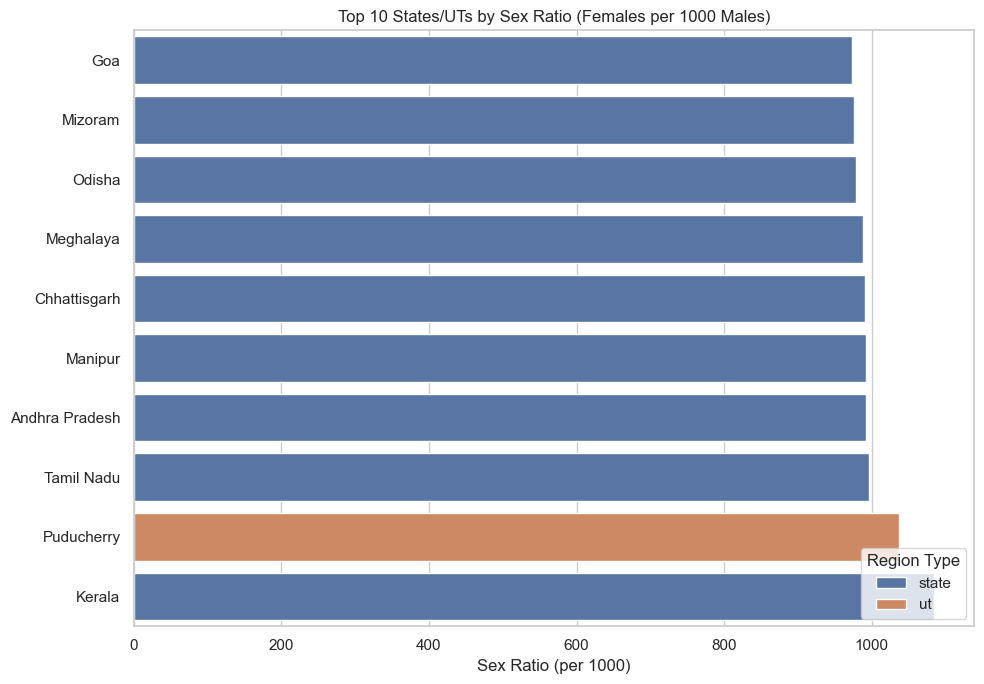

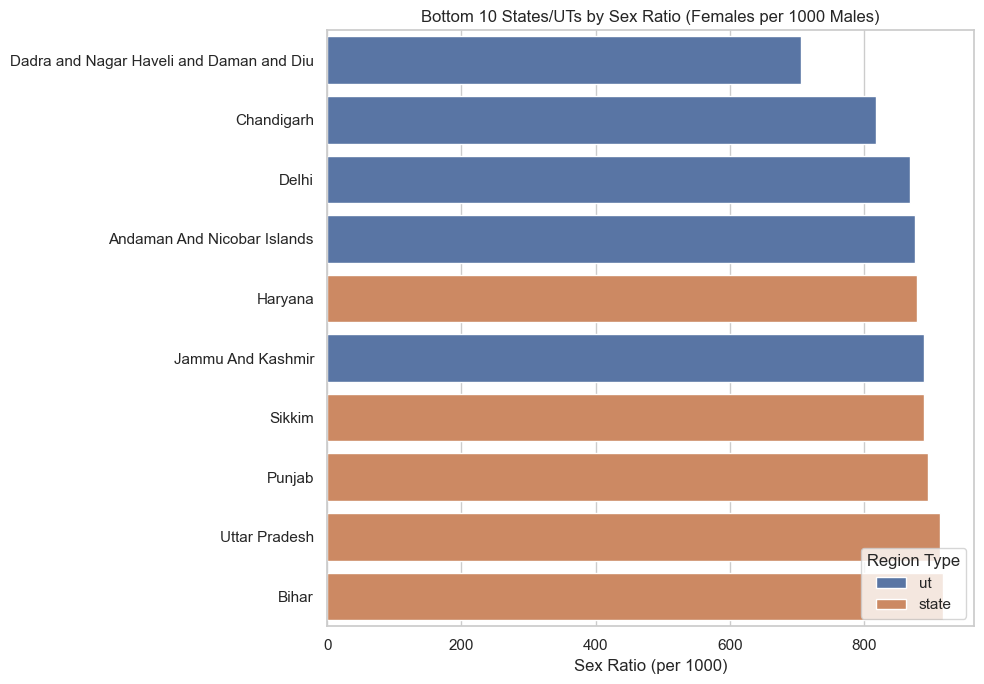

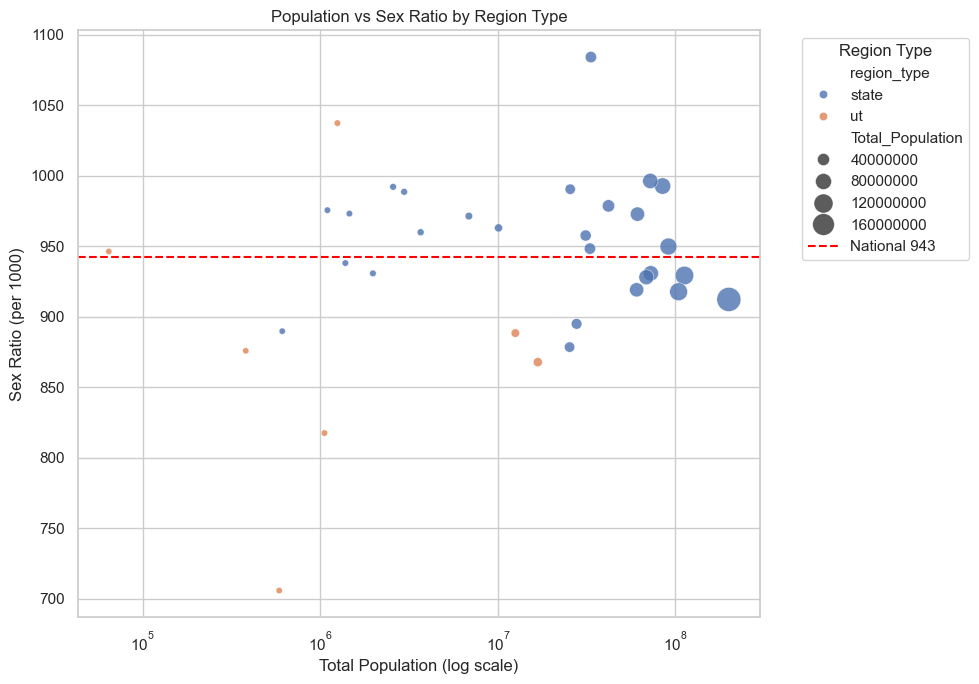

India GeoJSON not found. Upload a states/UT GeoJSON as a dataset/input.


In [37]:
# Section 10: Visualization: Top/Bottom States by Sex Ratio (Bar)
import matplotlib.ticker as mticker

viz_df = no_nat.dropna(subset=["sex_ratio_per_1000"]).copy()
# Coerce dtypes for plotting (avoid pandas nullable Int64 issues)
viz_df["Total_Population"] = pd.to_numeric(viz_df["Total_Population"], errors="coerce").astype(float)
viz_df["sex_ratio_per_1000"] = pd.to_numeric(viz_df["sex_ratio_per_1000"], errors="coerce").astype(float)

# Top 10
top10 = viz_df.nlargest(10, "sex_ratio_per_1000").sort_values("sex_ratio_per_1000")
plt.figure(figsize=(10, 7))
sns.barplot(data=top10, x="sex_ratio_per_1000", y="canonical_name", hue="region_type", dodge=False)
plt.title("Top 10 States/UTs by Sex Ratio (Females per 1000 Males)")
plt.xlabel("Sex Ratio (per 1000)")
plt.ylabel("")
plt.gca().xaxis.set_major_formatter(mticker.FormatStrFormatter('%.0f'))
plt.legend(title="Region Type", loc="lower right")
plt.tight_layout()
plt.savefig(OUT_DIR / "top10_sex_ratio.png", dpi=200)
plt.show()

# Bottom 10
bottom10 = viz_df.nsmallest(10, "sex_ratio_per_1000").sort_values("sex_ratio_per_1000")
plt.figure(figsize=(10, 7))
sns.barplot(data=bottom10, x="sex_ratio_per_1000", y="canonical_name", hue="region_type", dodge=False)
plt.title("Bottom 10 States/UTs by Sex Ratio (Females per 1000 Males)")
plt.xlabel("Sex Ratio (per 1000)")
plt.ylabel("")
plt.gca().xaxis.set_major_formatter(mticker.FormatStrFormatter('%.0f'))
plt.legend(title="Region Type", loc="lower right")
plt.tight_layout()
plt.savefig(OUT_DIR / "bottom10_sex_ratio.png", dpi=200)
plt.show()

# Section 11: Visualization: Population vs Sex Ratio Scatter
plt.figure(figsize=(10,7))
sns.scatterplot(data=viz_df, x="Total_Population", y="sex_ratio_per_1000", hue="region_type", size="Total_Population", sizes=(20, 300), alpha=0.8)
plt.xscale("log")
plt.axhline(nat_ratio, color="red", linestyle="--", label=f"National {nat_ratio:.0f}")
plt.xlabel("Total Population (log scale)")
plt.ylabel("Sex Ratio (per 1000)")
plt.title("Population vs Sex Ratio by Region Type")
plt.legend(title="Region Type", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.savefig(OUT_DIR / "scatter_pop_vs_sexratio.png", dpi=200)
plt.show()

# Section 12: Optional Choropleth via Plotly (no geopandas required)
try:
    import json
    if px is None:
        raise ImportError("plotly not available")
    # Look for a local India states GeoJSON using the finder
    for name in [
        "india_states.geojson",
        "india_states_ut.geojson",
        "india_admin1.geojson",
    ]:
        gj_path = find_data_file(name)
        if gj_path:
            break
    if not gj_path:
        print("India GeoJSON not found. Upload a states/UT GeoJSON as a dataset/input.")
    else:
        with open(gj_path, "r", encoding="utf-8") as f:
            gj = json.load(f)
        # Try to detect the name property used in the GeoJSON
        props = gj.get("features", [{}])[0].get("properties", {})
        candidates = ["ST_NM", "st_nm", "NAME_1", "name", "NAME", "state_name"]
        name_key = next((k for k in candidates if k in props), None)
        if name_key is None:
            raise KeyError("Could not detect a state name property in GeoJSON properties")
        # Prepare data: exclude national row
        map_df = merged[merged["canonical_name"] != "INDIA"].copy()
        fig = px.choropleth(
            map_df,
            geojson=gj,
            locations="canonical_name",
            featureidkey=f"properties.{name_key}",
            color="sex_ratio_per_1000",
            color_continuous_scale="RdYlGn",
            hover_data={"Total_Population": True, "region_type": True, "sex_ratio_per_1000": ':.0f'},
            title="Sex Ratio by State/UT (Females per 1000 Males)",
        )
        fig.update_geos(fitbounds="locations", visible=False)
        fig.update_layout(margin=dict(l=0, r=0, t=40, b=0))
        html_path = OUT_DIR / "choropleth_sex_ratio.html"
        fig.write_html(str(html_path))
        print(f"Choropleth saved to: {html_path}")
        fig
except Exception as e:
    print("Choropleth error:", e)
    print("Provide a valid India states GeoJSON as a Kaggle input to enable the map.")

In [38]:
# Section 13: Programmatic Insights Summary
lines = []
if not np.isnan(nat_ratio):
    lines.append(f"National sex ratio (2011): {nat_ratio:.0f} females per 1000 males.")

hi = no_nat[no_nat["sex_ratio_delta_vs_national"] >= 25].sort_values("sex_ratio_delta_vs_national", ascending=False)[["canonical_name","sex_ratio_per_1000","sex_ratio_delta_vs_national"]]
lo = no_nat[no_nat["sex_ratio_delta_vs_national"] <= -25].sort_values("sex_ratio_delta_vs_national", ascending=True)[["canonical_name","sex_ratio_per_1000","sex_ratio_delta_vs_national"]]

lines.append("States >= +25 above national sex ratio:")
lines.extend([f"  - {r.canonical_name}: {r.sex_ratio_per_1000:.0f} (+{r.sex_ratio_delta_vs_national:.0f})" for _, r in hi.iterrows()])
lines.append("States <= -25 below national sex ratio:")
lines.extend([f"  - {r.canonical_name}: {r.sex_ratio_per_1000:.0f} ({r.sex_ratio_delta_vs_national:.0f})" for _, r in lo.iterrows()])

# Correlation
corr = no_nat["sex_ratio_per_1000"].corr(no_nat["Total_Population"].apply(np.log))
lines.append(f"Correlation between log(Total_Population) and sex ratio: {corr:.3f}")

# Counts by region_type
counts = no_nat["region_type"].value_counts(dropna=False).to_dict()
lines.append(f"Counts by region_type: {counts}")

print("\nINSIGHTS\n" + "\n".join(lines))

# Section 14: Save Cleaned/Merged Dataset and Export Figures
final_cols = [
    "State_UT", "canonical_name", "region_type",
    "Males", "Females", "Total_Population",
    "sex_ratio_per_1000", "sex_ratio_delta_vs_national", "female_share", "male_share"
]
final_df = merged[final_cols].copy()
final_path = RESULTS_DIR / "india_gender_regiontype_cleaned.csv"
final_df.to_csv(final_path, index=False)

print(f"Saved cleaned dataset to: {final_path}")
print("Figures saved:")
for fn in ["top10_sex_ratio.png", "bottom10_sex_ratio.png", "scatter_pop_vs_sexratio.png"]:
    p = OUT_DIR / fn
    print(f"  - {p} : {'EXISTS' if p.exists() else 'MISSING'}")

# Section 15: Lightweight Assertions/Tests
assert final_df["canonical_name"].nunique() == final_df.shape[0], "Duplicate canonical names found"

# Allow some rows to mismatch M+F and Total by small margins (but in this dataset they match exactly)
calc_total = final_df["Males"].fillna(0) + final_df["Females"].fillna(0)
assert (calc_total == final_df["Total_Population"].fillna(0)).mean() > 0.9, "Too many rows where M+F != Total"

# Plausible sex ratio bounds (wider to accommodate UT outliers like Daman & Diu)
sr = final_df["sex_ratio_per_1000"].dropna()
assert ((sr >= 550) & (sr <= 1200)).all(), "Sex ratio out of plausible range"

print("\nAll assertions passed. Notebook analysis complete.")


INSIGHTS
National sex ratio (2011): 943 females per 1000 males.
States >= +25 above national sex ratio:
  - Kerala: 1084 (+142)
  - Puducherry: 1037 (+95)
  - Tamil Nadu: 996 (+54)
  - Andhra Pradesh: 993 (+50)
  - Manipur: 992 (+50)
  - Chhattisgarh: 991 (+48)
  - Meghalaya: 989 (+46)
  - Odisha: 979 (+36)
  - Mizoram: 976 (+33)
  - Goa: 973 (+31)
  - Karnataka: 973 (+30)
  - Himachal Pradesh: 972 (+29)
States <= -25 below national sex ratio:
  - Dadra and Nagar Haveli and Daman and Diu: 706 (-237)
  - Chandigarh: 818 (-125)
  - Delhi: 868 (-75)
  - Andaman And Nicobar Islands: 876 (-67)
  - Haryana: 879 (-64)
  - Jammu And Kashmir: 889 (-54)
  - Sikkim: 890 (-53)
  - Punjab: 895 (-48)
  - Uttar Pradesh: 912 (-30)
Correlation between log(Total_Population) and sex ratio: 0.222
Counts by region_type: {'state': 27, 'ut': 7}
Saved cleaned dataset to: c:\Users\abhis\Downloads\data Science 2.0\notebooks\cache\india_gender_regiontype_cleaned.csv
Figures saved:
  - c:\Users\abhis\Downloads\d